<h1 align="center">Handwritten digits classification with SVM</h1>


# <a id=0>Table of contents</a>

1. [Introduction](#1)
    * [1.1. Project topic](#11)
    * [1.2 About the dataset](#12)
2. [Preparation](#2)
    * [2.1. Required libraries](#21)
    * [2.2. Load the dataset](#22)
3. [Exploratory data analysis](#3)
    * [3.1. Examine the data distribution](#31)
    * [3.2. Prototyping and principle components visulization](#32)
    * [3.3. Analysis outputs](#33)
4. [Modeling](#4)
    * [4.1. Creating training and test sets](#41)
    * [4.2. Support vector classifier](#42)
        * [4.2.1. RBF-SVC](#421)
        * [4.2.2. Linear-SVC](#422)
        * [4.2.3. Poly-SVC](#423)
        * [4.2.4. RBF-SVC scaled](#424)
        * [4.2.5. Analyis outputs](#425)
    * [4.3. Logsitic regression](#43)
        * [4.3.1. Default logistic regression](#431)
        * [4.3.2. GridSearchCV logistic regression](#432)
        * [4.3.3. Analysis output](#433)
5. [Conclusion](#5)
    * [5.1.](#51)

# <a id=1>1. Introduction</a>
[$\uparrow$ *Back to top*](#0)

## <a id=11>1.1. Project topic</a>
[$\uparrow$ *Back to top*](#0)

Handwritten digit recognition is a fundamental and important problem in the field of machine learning, with many practical applications such as automating postal code reading, processing bank checks, and reading traffic license plates. This small study focuses on applying the Support Vector Machine (SVM) model, a powerful supervised learning algorithm, to classify digit images (0-9) from Scikit-learn's `load_digits` dataset. 

The main objective of this report is to evaluate the overall performance of SVM on this image data and to address three specific research questions: 
1. Among the three common kernel types (linear, polynomial, and RBF), which kernel provides the highest classification accuracy? 
2. How does the performance of the best SVM model compare to that of a Logistic Regression model? 
3. What are the characteristics of the images that were misclassified by the model?

By answering these questions, I aim to identify the optimal approach for this problem.

## <a id=12>1.2. About the dataset</a>

In this project, I use ["Optical recognition of handwritten digits dataset"](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset) loaded straight from scikit learn library. From scikit learn user guide:
> Data Set Characteristics:
> - Number of Instances: 1797
> - Number of Attributes: 64
> - Attribute Information: 8x8 image of integer pixels in the range 0..16.
> - Missing Attribute Values: None
> - Creator: Alpaydin (alpaydin ‘@’ boun.edu.tr)
> - Date: July; 1998
> 
> This is a copy of the test set of the UCI ML hand-written digits datasets https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits
>
> The data set contains images of hand-written digits: 10 classes where each class refers to a digit.
>
> Preprocessing programs made available by NIST were used to extract normalized bitmaps of handwritten digits from a preprinted form. From a total of 43 people, 30 contributed to the training set and different 13 to the test set. $32 \times 32$ bitmaps are divided into nonoverlapping blocks of 4x4 and the number of on pixels are counted in each block. **This generates an input matrix of $8 \times 8$ where each element is an integer in the range $0 \dots 16$. This reduces dimensionality and gives invariance to small distortions.**
>
> For info on NIST preprocessing routines, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.

# <a id=2>2. Preparation</a>
[$\uparrow$ *Back to top*](#0)

## <a id=21>2.1. Required libraries</a>
[$\uparrow$ *Back to top*](#0)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

Core Libraries
* `import numpy as np`:
    * NumPy (Numerical Python) is the fundamental library for scientific computing in Python. We used it for everything from storing the image data (as digits.data is a NumPy array) to efficiently performing vector and matrix operations.
* `import matplotlib.pyplot as plt`:
    * Matplotlib is the primary 2D visualization library. We used its pyplot module (aliased as plt) to draw every plot in this project, including: displaying the 8x8 digit images, the bar and pie charts for class distribution, the PCA scatter plot, the Confusion Matrix, and the ROC curves.

* Data Loading & Preprocessing: All of these modules come from Scikit-learn (sklearn), our main machine learning library.
    * `from sklearn.datasets import load_digits`: This is a utility function used to load the built-in digits dataset directly, saving us from having to process external image files.
    * `from sklearn.model_selection import train_test_split`: A critically important function. We used this to split our data (digits.data and digits.target) into two sets: a training set to "teach" the model and a testing set to evaluate its performance on unseen data.
    * `from sklearn.preprocessing import StandardScaler`: We used StandardScaler to experiment with standardizing the data. It transforms features (e.g., pixel values from 0-16) to have a mean of 0 and a variance of 1. This was crucial for getting LogisticRegression to converge properly.
    * `from sklearn.preprocessing import label_binarize`: This module was used for a very specific purpose: plotting multiclass ROC curves. To compare "class 3" vs. "all other classes," we needed to convert our y_test labels (e.g., [1, 3, 2, 3]) into a binary format (e.g., [0, 1, 0, 1] for class 3).
* Machine Learning Models: 
    * `from sklearn.svm import SVC`: This was our primary model. Support Vector Classification (SVC) is the class that implements the Support Vector Machine algorithm. We used it to train classifiers with different kernels (linear, poly, rbf).
    * `from sklearn.linear_model import LogisticRegression`: This was our baseline comparison model. LogisticRegression is another powerful linear model for classification that we used to contrast performance against the SVM.
* Model Evaluation
    * `from sklearn.metrics import accuracy_score`: This was our main evaluation metric. It calculates the percentage of predictions (y_pred) that exactly matched the true labels (y_test).
    * `from sklearn.metrics import classification_report`: Provides a detailed text summary. We used this to see the precision, recall, and f1-score for each individual digit (0, 1, 2,...), helping us understand where the model performed well (or poorly).
    * `from sklearn.metrics import ConfusionMatrixDisplay`: A visualization tool. We used this to plot the Confusion Matrix, which shows exactly which digits were confused for which other digits (e.g., an '8' being predicted as a '1').
    * `from sklearn.metrics import auc, roc_curve`: These functions are used for advanced evaluation. roc_curve computes the points on the Receiver Operating Characteristic (ROC) curve, and auc (Area Under the Curve) calculates the area beneath it to give us a single-number score of classifier performance.
* Feature Analysis
    * `from sklearn.decomposition import PCA`: Principal Component Analysis. This is not a classification model, but an Exploratory Data Analysis (EDA) tool. We used it to "compress" the 64 dimensions (pixels) down to 2 dimensions so we could create a scatter plot and see the digit clusters, which helped us understand why the non-linear RBF kernel worked best.

## <a id=22>2.2. Load the dataset</a>
[$\uparrow$ *Back to top*](#0)

In [2]:
digits = load_digits()

In [3]:
X = digits.data
y = digits.target

Let's have a quick look on the data inside this dataset

In [4]:
X.shape

(1797, 64)

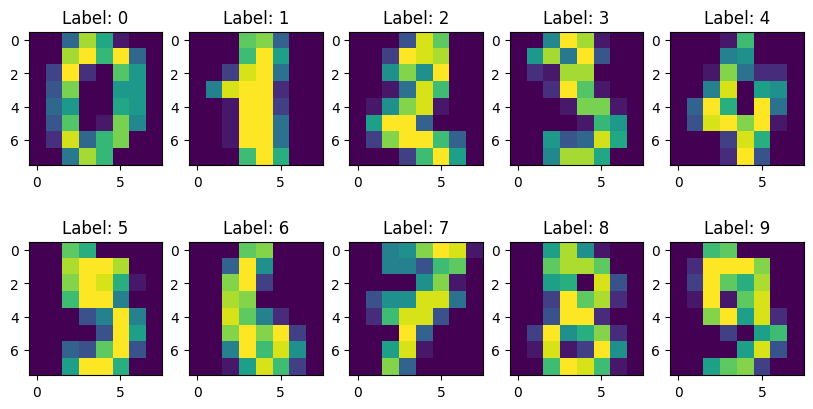

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    ax = axes.flatten()[i]
    img = digits.images[i]
    ax.imshow(img)
    ax.set_title(f"Label: {i}")

# <a id=3>3. Exploratory data analysis</a>
[$\uparrow$ *Back to top*](#0)

## <a id=31>3.1. Examine the data distribution</a> 
[$\uparrow$ *Back to top*](#0)

First, let's simply count all the samples that we have for each class.

In [6]:
classes, counts = np.unique(digits.target, return_counts=True)

for cl, cnt in zip(classes, counts):
    print(f"Class: {cl}; Count: {cnt}")

Class: 0; Count: 178
Class: 1; Count: 182
Class: 2; Count: 177
Class: 3; Count: 183
Class: 4; Count: 181
Class: 5; Count: 182
Class: 6; Count: 181
Class: 7; Count: 179
Class: 8; Count: 174
Class: 9; Count: 180


Let's plot a bar chart and a pie chart to visually examine the distribution of classes in the dataset. 

In [7]:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

([<matplotlib.axis.XTick at 0x1918898d850>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

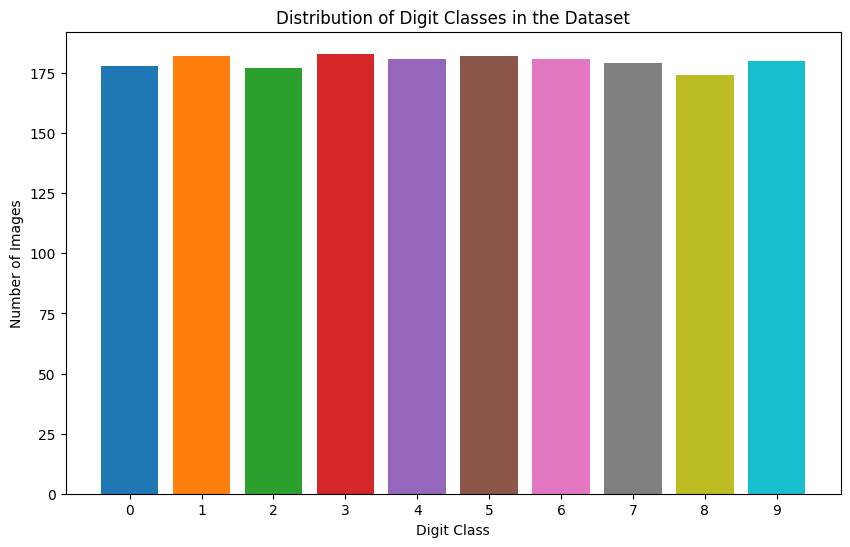

In [8]:
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color=colors)

plt.xlabel('Digit Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Digit Classes in the Dataset')

plt.xticks(classes)

(np.float64(-1.099999962950892),
 np.float64(1.0999999376204501),
 np.float64(-1.09999998115122),
 np.float64(1.0999999441528936))

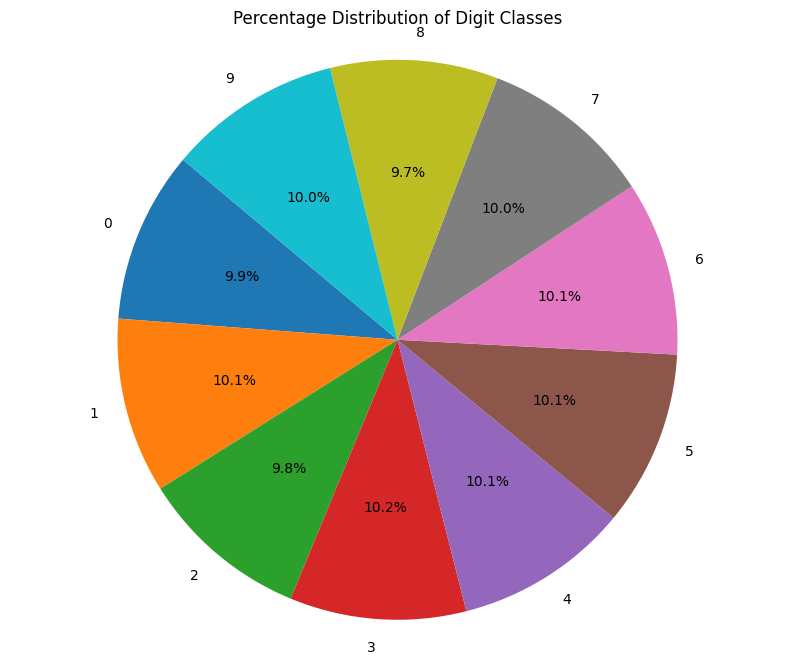

In [9]:
plt.figure(figsize=(10, 8))

plt.pie(counts,
        labels=classes,
        colors=colors,
        autopct='%1.1f%%',
        startangle=140)

plt.title('Percentage Distribution of Digit Classes')

plt.axis('equal')

## <a id=32>3.2. Prototyping and principle components visulization</a>
[$\uparrow$ *Back to top*](#0)

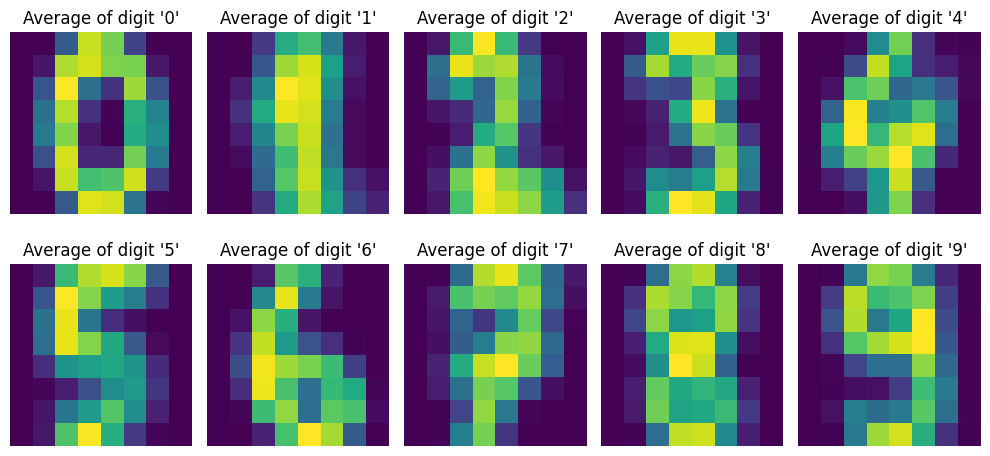

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i in range(10):
    images_of_this_digit = X[y == i]
    mean_image = np.mean(images_of_this_digit, axis=0)
    ax = axes.flatten()[i]
    
    ax.imshow(mean_image.reshape(8, 8))
    
    ax.set_axis_off()
    ax.set_title(f"Average of digit '{i}'")

plt.tight_layout()
plt.show()

To gain a deeper understanding of the features of each class, we calculated and visualized the "average" image for each digit.

In [11]:
pca = PCA(n_components=2)

In [12]:
X_pca = pca.fit_transform(digits.data)

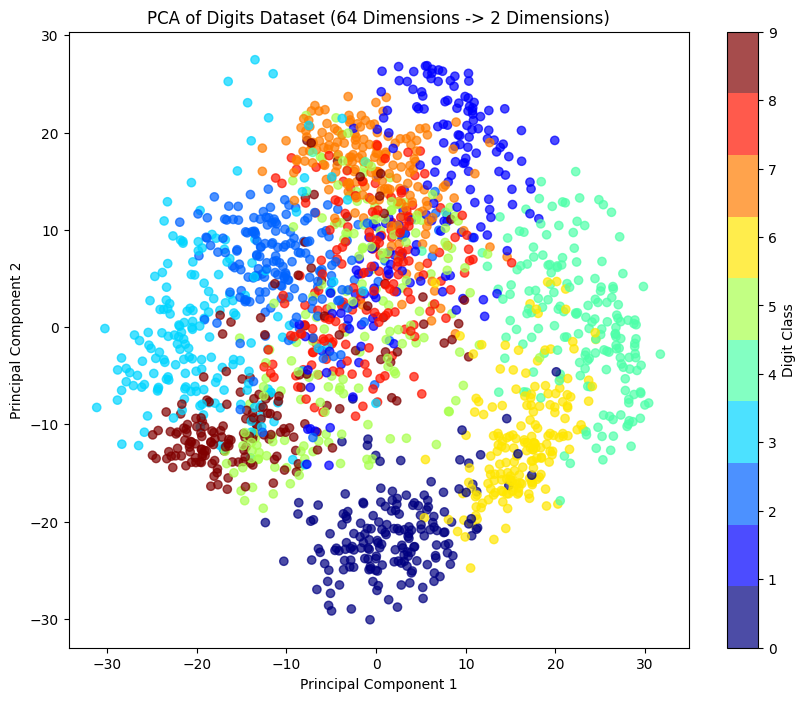

In [13]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.get_cmap('jet', 10), alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Digits Dataset (64 Dimensions -> 2 Dimensions)')

cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Digit Class')

Finally, we used Principal Component Analysis (PCA) to visualize the 64-dimensional feature space in 2 dimensions.

## <a id=33>3.3. Analysis outputs</a>
[$\uparrow$ *Back to top*](#0)

* The visualization results show that this dataset is highly balanced as expected, with each digit (0-9) accounting for approximately 10% of the total samples. This balance is important as it allows us to use Accuracy as a reliable performance metric.
* The prototyping analysis revealed that the core features (the bright regions) of each digit are very distinct, for example, the vertical line of the 'average 1' compared to the oval shape of the 'average 0'.
* Using PCA, the resulting scatter plot shows that some classes (like '1', '4', and '6') form very distinct clusters, while other classes (especially '2', '3', '7', and '8') overlap significantly in the central region. This might impose that the results will be better for non-linear models compare to linear models.

# <a id=4>4. Modeling</a>
[$\uparrow$ *Back to top*](#0)

## <a id=41>4.1.Create training and test sets</a>
[$\uparrow$ *Back to top*](#0)

Let's create training and test sets using `train_test_split` method with the ratio of **8:2** for **training:test**. We also set the `random_state` to make sure this cell run similarly on different computers. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size = 0.2, random_state = 0)

## <a id=42>4.2. Support vector classifier</a>
[$\uparrow$ *Back to top*](#0)

### <a id=421>4.2.1. Radial Basis Function kernel (RBF-SVC)</a>
[$\uparrow$ *Back to top*](#0)

In the default settings of the `SVC` `module`, the default kernel is set to the Radial Basis Function kernel (RBF).

In [15]:
svc_rbf = SVC()

In [16]:
svc_rbf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [17]:
svc_rbf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [18]:
y_rbf_pred = svc_rbf.predict(X_test)

In [19]:
acc_rbf = accuracy_score(y_test, y_rbf_pred)

In [20]:
acc_rbf

0.9916666666666667

Let's do a cross-validation before doing any further analysis on this first model `svc_rbf`

In [21]:
scores_rbf = cross_val_score(svc_rbf, X_test, y_test, cv = 10)

In [22]:
scores_rbf.mean()

np.float64(0.9666666666666666)

Now let's examine the mis-classification

In [23]:
error = (y_test != y_rbf_pred)

In [24]:
error

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,

In [25]:
error_indies = np.where(error)[0]

In [26]:
error_indies

array([124, 130, 181])

In [27]:
error_images = X_test[error_indies]

In [28]:
error_rbf_pred = y_rbf_pred[error_indies]
error_actl = y_test[error_indies]

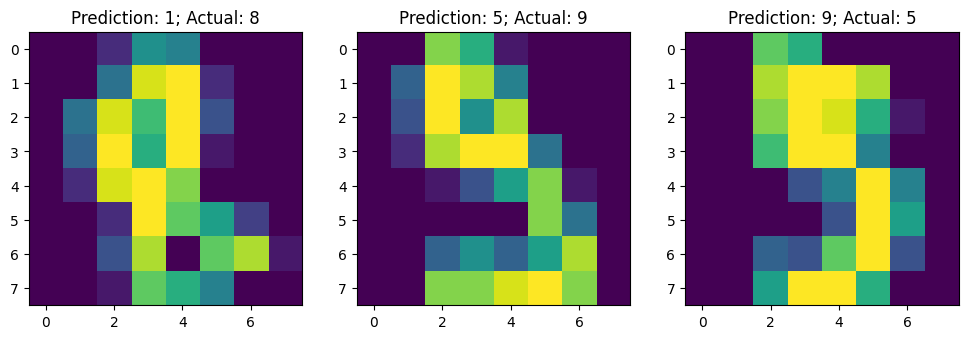

In [29]:
n_errors = len(error_indies)

fig, axes = plt.subplots(1, n_errors, figsize=(n_errors * 4, 4))

for i in range(n_errors):
    ax = axes[i]

    err_idx = error_indies[i]
    img = X_test[err_idx].reshape(8, 8)
    pred = y_rbf_pred[err_idx]
    actl = y_test[err_idx]

    ax.imshow(img)
    ax.set_title(f"Prediction: {pred}; Actual: {actl}")

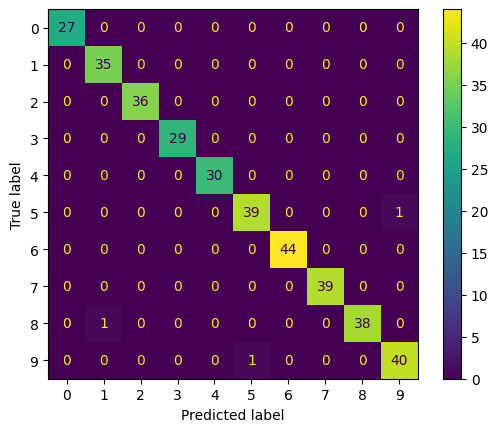

In [30]:
ConfusionMatrixDisplay.from_estimator(svc_rbf, X_test, y_test)

In [31]:
print(classification_report(y_test, y_rbf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.97      1.00      0.99        35
           2       1.00      1.00      1.00        36
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        30
           5       0.97      0.97      0.97        40
           6       1.00      1.00      1.00        44
           7       1.00      1.00      1.00        39
           8       1.00      0.97      0.99        39
           9       0.98      0.98      0.98        41

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



In [32]:
model_rbf_proba = SVC(
    probability=True
)

In [33]:
model_rbf_proba.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
y_rbf_proba_predict = model_rbf_proba.predict(X_test)
acc_rbf_proba = accuracy_score(y_test, y_rbf_proba_predict)
acc_rbf_proba

0.9916666666666667

In [35]:
y_rbf_proba = model_rbf_proba.predict_proba(X_test)

In [36]:
digits_classes = [i for i in range(0, 10)]
y_test_binarized = label_binarize(y_test, classes=digits_classes)

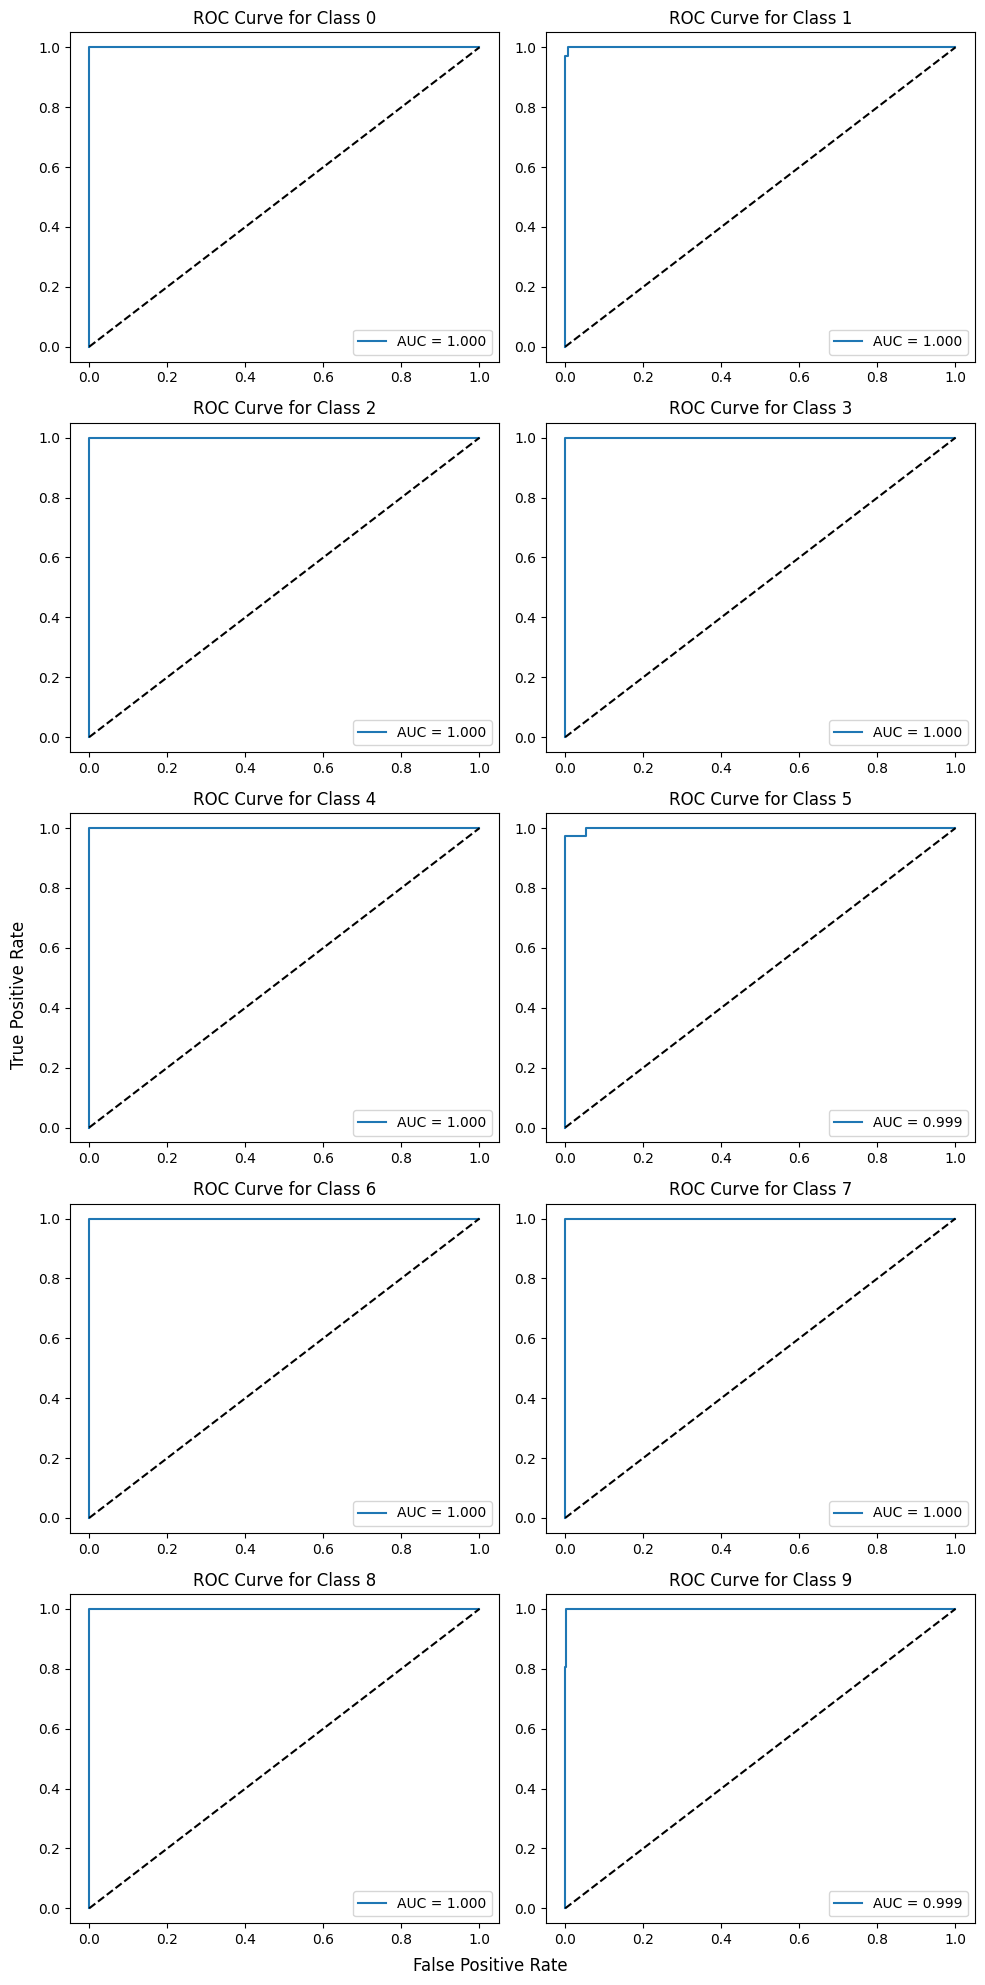

In [37]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for i in range(10):
    ax = axes.flatten()[i]

    true_labels = y_test_binarized[:, i]
    pred_scores = y_rbf_proba[:, i]

    fpr, tpr, _ = roc_curve(true_labels, pred_scores)
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_title(f'ROC Curve for Class {i}')
    ax.legend(loc="lower right")

fig.supxlabel('False Positive Rate')
fig.supylabel('True Positive Rate')

plt.tight_layout()

#### Quick analysis of [RBF-SVC](#421)
[$\uparrow$ *Back to top*](#0)
* In the first run, we got the accuracy of $99.167 \%$ with only 5 misclassification
* In cross validation, we got the average accuracy of $96.667 \%$

### <a id=422>4.2.2. Linear-SVC</a>
[$\uparrow$ *Back to top*](#0)

Now, we set the `kernel` parameter to `linear` as we want to use the linear kernel for SVC.

In [38]:
model_linear = SVC(
    kernel='linear'
)

In [39]:
model_linear.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [40]:
model_linear.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [41]:
y_linear_pred = model_linear.predict(X_test)

In [42]:
acc_linear = accuracy_score(y_test, y_linear_pred)

In [43]:
acc_linear

0.9777777777777777

In [44]:
acc_rbf

0.9916666666666667

In [45]:
scores_linear = cross_val_score(model_linear, X_test, y_test, cv = 10)

In [46]:
scores_linear.mean()

np.float64(0.961111111111111)

#### Quick analysis of [Linear-SVC](#422)
[$\uparrow$ *Back to top*](#0)
* In the first run, we got the accuracy of $97.778 \%$
* In cross validation, we got the average accuracy of $96.111 \%$

### <a id=423>4.2.3. Poly-SVC</a>
[$\uparrow$ *Back to top*](#0)

Now, we set the `kernel` parameter to `poly` as we want to use the polynomial kernel for SVC.

In [47]:
model_poly = SVC(
    kernel='poly'
)

In [48]:
model_poly.fit(X_train, y_train)

,C,1.0
,kernel,'poly'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [49]:
y_poly_pred = model_poly.predict(X_test)

In [50]:
acc_poly = accuracy_score(y_test, y_poly_pred)

In [51]:
acc_poly

0.9888888888888889

In [52]:
acc_rbf

0.9916666666666667

In [53]:
scores_poly = cross_val_score(model_poly, X_test, y_test, cv = 10)

In [54]:
scores_poly.mean()

np.float64(0.9666666666666666)

#### Quick analysis of [Poly-SVC](#423)
[$\uparrow$ *Back to top*](#0)
* In the first run, we got the accuracy of $98.889 \%$
* In cross validation, we got the average accuracy of $96.667 \%$

### <a id=424>4.2.4. RBF-SVC scaled</a>
[$\uparrow$ *Back to top*](#0)

Although the dataset's description suggests the data has already been quite thoroughly normalized, this step of attempting to scale the data was just to check whether-before performing any hyperparameter tuning-scaling the data could help us achieve a better result.

In [55]:
scaler = StandardScaler()

In [56]:
X_train_scaled = scaler.fit_transform(X_train)

In [57]:
X_test_scaled = scaler.transform(X_test)

In [58]:
model_scaled = SVC()

In [59]:
model_scaled.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [60]:
y_pred_scaled = model_scaled.predict(X_test_scaled)

In [61]:
acc_scaled = accuracy_score(y_test, y_pred_scaled)

In [62]:
acc_scaled

0.9805555555555555

In [63]:
scores_scaled = cross_val_score(model_scaled, X_test, y_test, cv=10)

In [64]:
scores_scaled.mean()

np.float64(0.9666666666666666)

#### Quick analysis of [RBF-SVC scaled](#423)
[$\uparrow$ *Back to top*](#0)
* In the first run, we got the accuracy of $98.056 \%$
* In cross validation, we got the average accuracy of $96.667 \%$

### <a id=425>4.2.5. Analysis output</a>
[$\uparrow$ *Back to top*](#0)

| Model          | CV mean    |
|----------------|------------|
| RBF-SVC        | $96.667\%$ |
| Poly-SVC       | $96.667\%$ |
| RBF-SVC scaled | $96.667\%$ |
| Linear-SVC     | $96.111\%$ |

From the average results obtained from all SVC models, we can observe:
* The non-linear models achieved a higher average accuracy compared to the linear model.
* Scaling the data did not produce a significant breakthrough, as the average cross-validation result was on par with the model run on unscaled data. It can be concluded that the data available in the dataset was already normalized well enough to be run with SVC.

### <a id=43>4.3. Logistic regression</a>
[$\uparrow$ *Back to top*](#0)

Tiếp theo, như đã nói ở mục đính nghiên cứu, ta sẽ sử dụng model logistic regression để chạy trên dataset này và so sánh kết quả của nó với SVC. 

### <a id=431>4.3.1. Default logistic regression</a>
[$\uparrow$ *Back to top*](#0)

In [65]:
logreg = LogisticRegression()

In [66]:
logreg.fit(X_train, y_train)

C:\Users\al\Programming\handwritten-digits-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Seems like logistic regression have some trouble connverging with the default hyperparameter, let's increase it's `max_iter` to 1000.

In [67]:
logreg_moreiter = LogisticRegression(
    max_iter=1000
)

In [68]:
logreg_moreiter.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [69]:
y_logreg_pred = logreg_moreiter.predict(X_test)

In [70]:
acc_logreg = accuracy_score(y_test, y_logreg_pred)

In [71]:
acc_logreg

0.9694444444444444

In [72]:
scores_logreg = cross_val_score(logreg_moreiter, X_test, y_test, cv=10)

In [73]:
scores_logreg.mean()

np.float64(0.9527777777777778)

#### Quick analysis of [default logistic regression](#431)
[$\uparrow$ *Back to top*](#0)
* In the first run, we got the accuracy of $96.944 \%$
* In cross validation, we got the average accuracy of $95.278 \%$

### <a id=432>4.3.2. GridSearchCV logistic regression</a>
[$\uparrow$ *Back to top*](#0)

Let's try improving logistic regression score my finding suitable hyperparameters for the model.

In [74]:
param_grid = [
    {
        'solver': ['lbfgs'],
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 5000]
    },
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 5000]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 5000]
    }
]

In [76]:
logreg_tune = LogisticRegression()

In [77]:
grid_search = GridSearchCV(estimator=logreg_tune, 
                           param_grid=param_grid, 
                           cv=10, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

In [78]:
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


,estimator,LogisticRegression()
,param_grid,"[{'C': [0.01, 0.1, ...], 'max_iter': [1000, 5000], 'penalty': ['l2'], 'solver': ['lbfgs']}, {'C': [0.01, 0.1, ...], 'max_iter': [1000, 5000], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}, ...]"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [79]:
grid_search.best_params_

{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}

In [80]:
logreg_best = grid_search.best_estimator_

In [81]:
acc_logreg_best = logreg_best.score(X_test, y_test)

In [82]:
acc_logreg_best

0.9666666666666667

#### Quick analysis of [tunned logistic regression](#432)
[$\uparrow$ *Back to top*](#0)
* After tuning, the best score logistic regression could give us is $96.667 \%$

### <a id=433>4.3.3. Analysis output</a>
[$\uparrow$ *Back to top*](#0)

| Model                | CV mean    |
|----------------------|------------|
| RBF-SVC              | $96.667\%$ |
| Poly-SVC             | $96.667\%$ |
| RBF-SVC scaled       | $96.667\%$ |
| Linear-SVC           | $96.111\%$ |
| Logistic regression  | $95.278\%$ |

From this table, we could draw some analysis on logistic regression model performance:
* It's performance is not actually bad, but not as good as what we got with VC, even compare to Linear-SVC
* The best hyperparameter we got from `GridSearchCV` could just give the best score of $96.667\%$ - the average performance of SVC models.

# <a id=5>5. Conclusion</a>
[$\uparrow$ *Back to top*](#0)

The notebook has gone through essential analysis and experiment that we could answer the stated questions from the beginning of the research:

* **Which kernel provided the highest accuracy**: The RBF kernel ($99.16\%$) yielded the highest prediction score, followed by poly ($98.88\%$) and linear ($97.77\%$). In average tests using 10-folds cross validation, the performance of non-linear kernel results in better overal performance of $96.667\%$. This result is perfectly consistent with our EDA. The PCA plot showed that the data clusters overlap significantly, requiring a non-linear decision boundary to separate them. The RBF kernel (and to a lesser extent, poly) is capable of creating these complex boundaries, whereas the linear kernel is restricted and thus had lower performance.
* **How does SVM compare to Logistic Regression?** In 10-folds cross validation, SVM ($96.667\%$) significantly outperformed Logistic Regression ($95.278\%$). Although Logistic Regression is a strong baseline model, the SVM's ability to find an optimal separating hyperplane in a high-dimensional feature space (using the kernel trick) proved to be more effective for this problem.
* **Which images were misclassified? Why?** Our error analysis showed that the errors were not random. The only three mistakes (8 to 1, 5 to 9, 9 to 5) occurred on samples with very ambiguous shapes. For example, the '8' image was missing its characteristic curves, and the '5' and '9' were written with missing/extra strokes, making them look like each other. These samples lie on the model's decision boundary and could even be misclassified by a human.

Potential limitations:

* This study has several limitations. First, the sklearn digits dataset is a "clean" and balanced subset, which may not reflect the complexity of real-world handwritten data (for example, the full MNIST dataset).
* Second, we used the default hyperparameters for the models. Although excellent results were achieved, further fine-tuning (e.g., using `GridSearchCV` to find the optimal C and gamma) could potentially improve performance even more.

In conclusion, this study has demonstrated that the Support Vector Machine is an extremely powerful and effective tool for handwritten digit recognition. The RBF-SVM model achieved near-perfect accuracy (99.16%), outperforming the linear and poly kernels, as well as the Logistic Regression model.

Our results confirm that the success of SVM comes from its ability to model complex non-linear relationships in the data via the RBF kernel, which is crucial for separating digits with similar shapes. We recommend using the RBF-SVM as a strong baseline for similar low-resolution image classification tasks.